In [ ]:
!pip install fair-esm torch

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import torch
print(torch.cuda.is_available())

False


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, cohen_kappa_score
)
import matplotlib.pyplot as plt
import esm
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Load ESM model
esm_model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
esm_model.eval()

# Dataset Class with data augmentation
class PeptideDataset(Dataset):
    def __init__(self, csv_file, augment=False):
        df = pd.read_csv(csv_file)
        self.sequences = df['sequence'].astype(str).tolist()
        self.labels = df['anticancer'].tolist()
        self.augment = augment

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]

        # Simple data augmentation - reverse sequence
        if self.augment and torch.rand(1).item() > 0.5:
            seq = seq[::-1]

        return seq, label

# ESM Embedding Extractor with caching
@torch.no_grad()
def extract_esm_embeddings(sequences):
    sequences_upper = [seq.upper() for seq in sequences]
    data = [("seq", seq) for seq in sequences_upper]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    results = esm_model(batch_tokens, repr_layers=[6], return_contacts=False)
    token_representations = results["representations"][6]

    embeddings = []
    for i, seq in enumerate(sequences_upper):
        emb = token_representations[i, 1:len(seq)+1].mean(0)
        embeddings.append(emb)
    return torch.stack(embeddings)

# Improved TCN Blocks
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(n_outputs)
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(n_outputs)
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.bn1, nn.GELU(), self.dropout1,
            self.conv2, self.chomp2, self.bn2, nn.GELU(), self.dropout2
        )
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in')  # removed nonlinearity
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in')  # removed nonlinearity
        if self.downsample is not None:
            nn.init.kaiming_normal_(self.downsample.weight, mode='fan_in')  # removed nonlinearity

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return F.gelu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers.append(
                TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                            dilation=dilation_size, padding=(kernel_size - 1) * dilation_size,
                            dropout=dropout)
            )
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Improved Adaptive Feature Fusion
class AdaptiveFusion(nn.Module):
    def __init__(self, esm_dim, tcn_dim):
        super().__init__()
        self.fc_esm = nn.Sequential(
            nn.Linear(esm_dim, esm_dim),
            nn.LayerNorm(esm_dim),
            nn.GELU()
        )
        self.fc_tcn = nn.Sequential(
            nn.Linear(tcn_dim, esm_dim),
            nn.LayerNorm(esm_dim),
            nn.GELU()
        )
        self.gate = nn.Sequential(
            nn.Linear(esm_dim * 2, esm_dim),
            nn.Sigmoid()
        )

    def forward(self, esm_feat, tcn_feat):
        esm_proj = self.fc_esm(esm_feat)
        tcn_proj = self.fc_tcn(tcn_feat)

        combined = torch.cat([esm_proj, tcn_proj], dim=1)
        gate = self.gate(combined)

        return gate * esm_proj + (1 - gate) * tcn_proj

# Label Smoothing Cross Entropy
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, x, target):
        log_probs = F.log_softmax(x, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Improved LSTM with LayerNorm and dropout
class LayerNormLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Layer normalization
        self.ln_i = nn.LayerNorm(hidden_size)
        self.ln_h = nn.LayerNorm(hidden_size)
        self.ln_c = nn.LayerNorm(hidden_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Apply layer normalization
        hn = self.ln_h(hn)
        cn = self.ln_c(cn)

        return out, (hn, cn)

# Complete Classifier Model with improvements
class MultimodalClassifier(nn.Module):
    def __init__(self, esm_dim=320, tcn_input=21, tcn_channels=[64, 128], lstm_hidden=128, num_classes=2):
        super().__init__()

        # TCN pathway
        self.tcn = TCN(tcn_input, tcn_channels)

        # Feature fusion
        self.fusion = AdaptiveFusion(esm_dim, tcn_channels[-1])

        # LSTM pathway with layer normalization
        self.lstm = LayerNormLSTM(input_size=esm_dim, hidden_size=lstm_hidden,
                                num_layers=3, dropout=0.3)

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden, lstm_hidden // 2),
            nn.LayerNorm(lstm_hidden // 2),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(lstm_hidden // 2, num_classes)
        )

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                if param.dim() < 2:  # Skip initialization for 1D tensors
                    continue
                if 'lstm' in name.lower():
                    nn.init.orthogonal_(param)
                else:
                    nn.init.kaiming_normal_(param, mode='fan_in')
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, esm_feats, onehot_seqs):
        # TCN pathway
        tcn_out = self.tcn(onehot_seqs.permute(0, 2, 1))
        tcn_summary = torch.mean(tcn_out, dim=2)  # Global pooling

        # Feature fusion
        fused = self.fusion(esm_feats, tcn_summary)

        # Prepare LSTM input (repeat fused features to simulate sequence)
        lstm_input = fused.unsqueeze(1).repeat(1, 10, 1)

        # LSTM pathway
        lstm_out, _ = self.lstm(lstm_input)

        # Classifier
        out = self.classifier(lstm_out[:, -1])
        return out

# Improved training function with gradient clipping, warmup, and more
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50,
               patience=5, grad_clip=1.0, grad_accum_steps=4):
    history = {"train_loss": [], "val_loss": []}
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Learning rate schedulers
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, lambda epoch: min(1.0, (epoch + 1) / 10))
    reduce_lr = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()

        for i, (sequences, labels) in enumerate(tqdm(train_loader)):
            esm_feats = extract_esm_embeddings(sequences)
            onehot_seqs = sequence_to_onehot(sequences).float()
            labels = torch.tensor(labels).long()

            outputs = model(esm_feats, onehot_seqs)
            loss = criterion(outputs, labels) / grad_accum_steps
            loss.backward()

            train_loss += loss.item() * grad_accum_steps

            # Gradient accumulation
            if (i + 1) % grad_accum_steps == 0 or (i + 1) == len(train_loader):
                # Gradient clipping
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                optimizer.zero_grad()

        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                esm_feats = extract_esm_embeddings(sequences)
                onehot_seqs = sequence_to_onehot(sequences).float()
                labels = torch.tensor(labels).long()

                outputs = model(esm_feats, onehot_seqs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history["val_loss"].append(val_loss)

        # Learning rate scheduling
        if epoch < 10:  # Warmup phase
            warmup_scheduler.step()
        else:
            reduce_lr.step(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping at epoch {epoch+1}')
                model.load_state_dict(torch.load('best_model.pt'))
                break

    return history

# Utility Functions
def sequence_to_onehot(sequences, max_len=100):
    amino_acids = 'RHKDESTNQCUGPAVILMFYW'
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
    onehot = torch.zeros(len(sequences), max_len, len(amino_acids))
    for i, seq in enumerate(sequences):
        seq_upper = seq.upper()
        for j, aa in enumerate(seq_upper[:max_len]):
            if aa in aa_to_idx:
                onehot[i, j, aa_to_idx[aa]] = 1.0
    return onehot

def evaluate_model(model, data_loader):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for sequences, labels in data_loader:
            esm_feats = extract_esm_embeddings(sequences)
            onehot_seqs = sequence_to_onehot(sequences).float()
            outputs = model(esm_feats, onehot_seqs)
            preds = torch.argmax(outputs, dim=1).numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    metrics = {
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Precision": precision_score(all_labels, all_preds),
        "Recall": recall_score(all_labels, all_preds),
        "F1-score": f1_score(all_labels, all_preds),
        "MCC": matthews_corrcoef(all_labels, all_preds),
        "Cohen's Kappa": cohen_kappa_score(all_labels, all_preds)
    }

    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    return metrics

def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training/Validation Loss")
    plt.show()

  0%|                                                  | 0/1109 [00:00<?, ?it/s]/home/molecular16/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipykernel_1233598/3237775690.py:267: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long()
100%|███████████████████████████████████████| 1109/1109 [00:44<00:00, 25.00it/s]
/tmp/ipykernel_1233598/3237775690.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long()


Epoch 1, Train Loss: 0.6956, Val Loss: 0.6291, LR: 2.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.47it/s]


Epoch 2, Train Loss: 0.6364, Val Loss: 0.5973, LR: 3.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.34it/s]


Epoch 3, Train Loss: 0.6093, Val Loss: 0.5726, LR: 4.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.50it/s]


Epoch 4, Train Loss: 0.5861, Val Loss: 0.5714, LR: 5.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.64it/s]


Epoch 5, Train Loss: 0.5618, Val Loss: 0.5394, LR: 6.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:44<00:00, 24.83it/s]


Epoch 6, Train Loss: 0.5421, Val Loss: 0.5173, LR: 7.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.34it/s]


Epoch 7, Train Loss: 0.5184, Val Loss: 0.4917, LR: 8.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.39it/s]


Epoch 8, Train Loss: 0.4997, Val Loss: 0.4806, LR: 9.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.53it/s]


Epoch 9, Train Loss: 0.4813, Val Loss: 0.5034, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.17it/s]


Epoch 10, Train Loss: 0.4623, Val Loss: 0.4450, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:44<00:00, 25.01it/s]


Epoch 11, Train Loss: 0.4435, Val Loss: 0.4432, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.19it/s]


Epoch 12, Train Loss: 0.4193, Val Loss: 0.4243, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 24.00it/s]


Epoch 13, Train Loss: 0.4042, Val Loss: 0.4099, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.73it/s]


Epoch 14, Train Loss: 0.3885, Val Loss: 0.3808, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.79it/s]


Epoch 15, Train Loss: 0.3716, Val Loss: 0.3648, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.77it/s]


Epoch 16, Train Loss: 0.3609, Val Loss: 0.3440, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.21it/s]


Epoch 17, Train Loss: 0.3484, Val Loss: 0.3500, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.29it/s]


Epoch 18, Train Loss: 0.3395, Val Loss: 0.3563, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.44it/s]


Epoch 19, Train Loss: 0.3309, Val Loss: 0.3377, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.24it/s]


Epoch 20, Train Loss: 0.3218, Val Loss: 0.3444, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.97it/s]


Epoch 21, Train Loss: 0.3160, Val Loss: 0.3593, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.63it/s]


Epoch 22, Train Loss: 0.3112, Val Loss: 0.3360, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.78it/s]


Epoch 23, Train Loss: 0.3048, Val Loss: 0.3399, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.68it/s]


Epoch 24, Train Loss: 0.2961, Val Loss: 0.3390, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:48<00:00, 23.09it/s]


Epoch 25, Train Loss: 0.2927, Val Loss: 0.3338, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.12it/s]


Epoch 26, Train Loss: 0.2889, Val Loss: 0.3400, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.55it/s]


Epoch 27, Train Loss: 0.2853, Val Loss: 0.3412, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:44<00:00, 24.67it/s]


Epoch 28, Train Loss: 0.2804, Val Loss: 0.3149, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.52it/s]


Epoch 29, Train Loss: 0.2793, Val Loss: 0.3056, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.79it/s]


Epoch 30, Train Loss: 0.2744, Val Loss: 0.3974, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:43<00:00, 25.29it/s]


Epoch 31, Train Loss: 0.2715, Val Loss: 0.2970, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 24.06it/s]


Epoch 32, Train Loss: 0.2681, Val Loss: 0.2976, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.70it/s]


Epoch 33, Train Loss: 0.2648, Val Loss: 0.3756, LR: 1.00e-04


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.39it/s]


Epoch 34, Train Loss: 0.2599, Val Loss: 0.3089, LR: 5.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.47it/s]


Epoch 35, Train Loss: 0.2438, Val Loss: 0.2859, LR: 5.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.70it/s]


Epoch 36, Train Loss: 0.2399, Val Loss: 0.2889, LR: 5.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.93it/s]


Epoch 37, Train Loss: 0.2373, Val Loss: 0.2775, LR: 5.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.52it/s]


Epoch 38, Train Loss: 0.2370, Val Loss: 0.2990, LR: 5.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 24.07it/s]


Epoch 39, Train Loss: 0.2365, Val Loss: 0.3033, LR: 5.00e-05


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.29it/s]


Epoch 40, Train Loss: 0.2354, Val Loss: 0.3145, LR: 2.50e-05


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.17it/s]


Epoch 41, Train Loss: 0.2252, Val Loss: 0.2904, LR: 2.50e-05


100%|███████████████████████████████████████| 1109/1109 [00:47<00:00, 23.49it/s]


Epoch 42, Train Loss: 0.2238, Val Loss: 0.2989, LR: 2.50e-05


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.61it/s]


Epoch 43, Train Loss: 0.2243, Val Loss: 0.3012, LR: 1.25e-05


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.96it/s]


Epoch 44, Train Loss: 0.2198, Val Loss: 0.2820, LR: 1.25e-05


100%|███████████████████████████████████████| 1109/1109 [00:45<00:00, 24.43it/s]


Epoch 45, Train Loss: 0.2195, Val Loss: 0.2949, LR: 1.25e-05


100%|███████████████████████████████████████| 1109/1109 [00:46<00:00, 23.73it/s]


Epoch 46, Train Loss: 0.2184, Val Loss: 0.2826, LR: 6.25e-06


100%|███████████████████████████████████████| 1109/1109 [00:44<00:00, 25.00it/s]


Epoch 47, Train Loss: 0.2153, Val Loss: 0.2809, LR: 6.25e-06
Early stopping at epoch 47


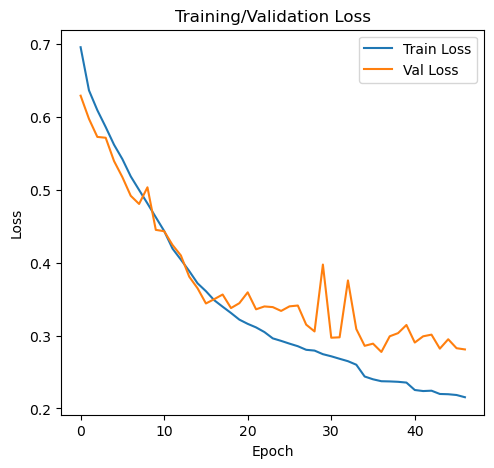


Train Set Evaluation:
Accuracy: 0.9871
Precision: 0.9877
Recall: 0.9865
F1-score: 0.9871
MCC: 0.9742
Cohen's Kappa: 0.9742

Validation Set Evaluation:


/home/molecular16/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.9571
Precision: 0.9580
Recall: 0.9562
F1-score: 0.9571
MCC: 0.9143
Cohen's Kappa: 0.9143


/home/molecular16/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


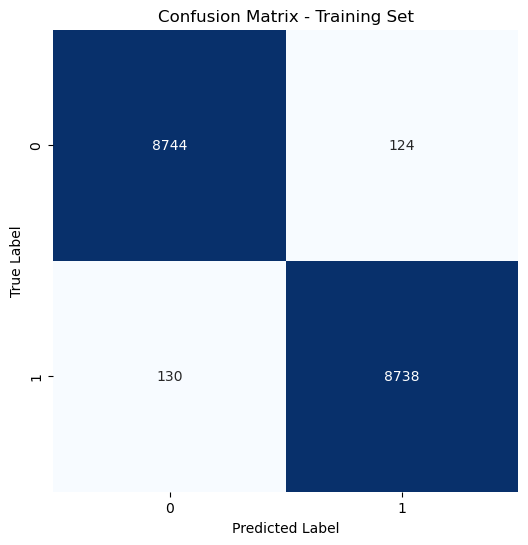

/home/molecular16/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


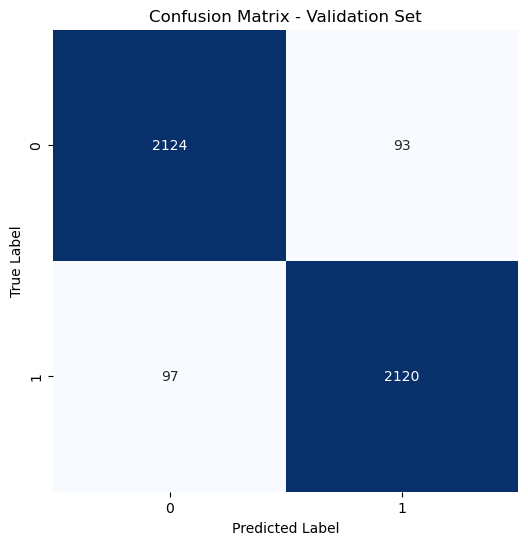

In [ ]:
# Main Execution
if __name__ == "__main__":
    # Initialize with data augmentation for training
    full_dataset = PeptideDataset("anticancer_augmented_balanced_data.csv", augment=True)

    # Stratified split
    from sklearn.model_selection import train_test_split
    indices = list(range(len(full_dataset)))
    labels = [full_dataset[i][1] for i in indices]
    train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)

    train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
    val_dataset = torch.utils.data.Subset(
        PeptideDataset("anticancer_augmented_balanced_data.csv", augment=False),
        val_idx
    )

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, num_workers=4, pin_memory=True)

    model = MultimodalClassifier()

    # Use label smoothing and gradient clipping
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    history = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        num_epochs=50, patience=10, grad_clip=1.0, grad_accum_steps=2
    )

    plot_history(history)

    print("\nTrain Set Evaluation:")
    train_metrics = evaluate_model(model, train_loader)

    print("\nValidation Set Evaluation:")
    val_metrics = evaluate_model(model, val_loader)

    # Confusion matrix plotting
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    def plot_confusion_matrix(model, data_loader, title):
        all_preds, all_labels = [], []
        with torch.no_grad():
            for sequences, labels in data_loader:
                esm_feats = extract_esm_embeddings(sequences)
                onehot_seqs = sequence_to_onehot(sequences).float()
                outputs = model(esm_feats, onehot_seqs)
                preds = torch.argmax(outputs, dim=1).numpy()
                all_preds.extend(preds)
                all_labels.extend(labels)

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(title)
        plt.show()

    plot_confusion_matrix(model, train_loader, "Confusion Matrix - Training Set")
    plot_confusion_matrix(model, val_loader, "Confusion Matrix - Validation Set")

/home/molecular16/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


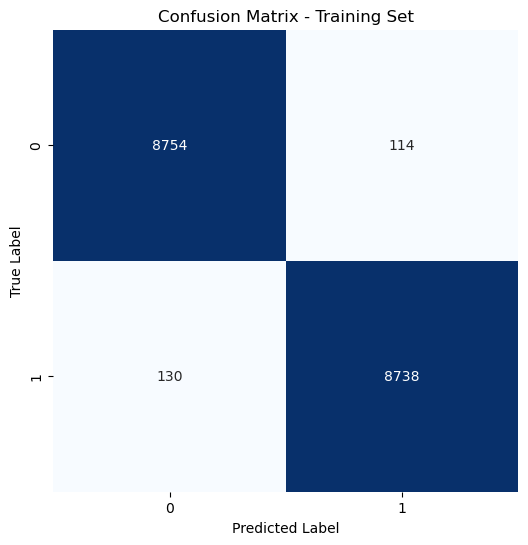

/home/molecular16/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


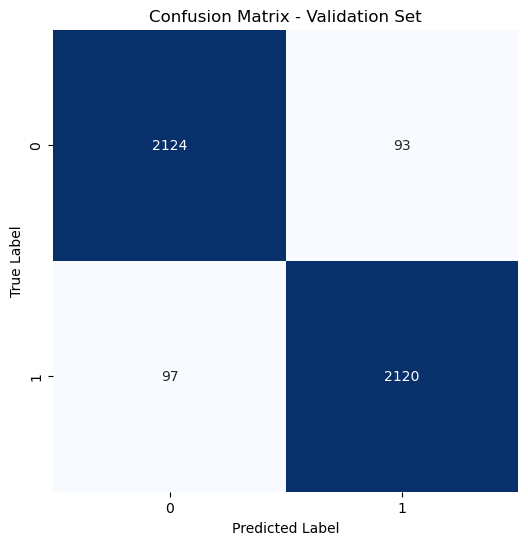

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, data_loader, title):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for sequences, labels in data_loader:
            esm_feats = extract_esm_embeddings(sequences)
            onehot_seqs = sequence_to_onehot(sequences).float()
            outputs = model(esm_feats, onehot_seqs)
            preds = torch.argmax(outputs, dim=1).numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(model, train_loader, "Confusion Matrix - Training Set")
plot_confusion_matrix(model, val_loader, "Confusion Matrix - Validation Set")


In [ ]:
import pandas as df
df = pd.read_csv("anticancer_augmented_balanced_data.csv")
FRS_counts = df['anticancer'].value_counts()
print(FRS_counts)

anticancer
1    11085
0    11085
Name: count, dtype: int64


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'anticancer_peptide_classifier.pth')

# To open the trained model, you would load the state dictionary back into a model instance
# First, instantiate a new model with the same architecture
loaded_model = MultimodalClassifier()

# Then, load the saved state dictionary
loaded_model.load_state_dict(torch.load('anticancer_peptide_classifier.pth'))

# Set the model to evaluation mode
loaded_model.eval()

print("Model loaded successfully!")

# You can now use loaded_model for inference on new data.
# Example (assuming you have new_sequences):
new_sequences = ["ARGLAKL", "AAVVRR"]
new_esm_feats = extract_esm_embeddings(new_sequences)
new_onehot_seqs = sequence_to_onehot(new_sequences).float()
with torch.no_grad():
     predictions = loaded_model(new_esm_feats, new_onehot_seqs)
     predicted_classes = torch.argmax(predictions, dim=1)
     print("Predictions:", predicted_classes)

Model loaded successfully!
Predictions: tensor([1, 0])


In [ ]:
!pip install lime

Defaulting to user installation because normal site-packages is not writeable


In [6]:
from lime.lime_text import LimeTextExplainer
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Load dataset ===
df = pd.read_csv("anticancer_augmented_balanced_data.csv")

# Drop sequences with length smaller than 6 and create a new dataframe
df_filtered = df[df['sequence'].str.len() >= 6].copy()
df = df_filtered

df['sequence'] = df['sequence'].astype(str)
df['label'] = df['anticancer']

# === Tokenization into k-mers ===
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i + k] for i in range(len(seq) - k + 1)])

k = 3
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))

# === Helper to reconstruct full sequence from k-mers ===
def kmers_to_seq(kmer_str, k=3):
    kmers = kmer_str.split()
    if not kmers:
        return ''
    return kmers[0] + ''.join([k[-1] for k in kmers[1:]])

# === Prediction wrapper for LIME (accepts k-mer strings) ===
class_names = ['non-anticancer', 'anticancer']

def lime_predict_kmers(kmer_texts):
    # Convert k-mer text back to raw sequences
    sequences = [kmers_to_seq(text, k) for text in kmer_texts]

    model.eval()
    with torch.no_grad():
        # Filter out invalid inputs
        valid_sequences = [seq for seq in sequences if isinstance(seq, str) and len(seq) > 0]
        if not valid_sequences:
            return np.array([[0.5, 0.5]] * len(sequences))

        # ESM and one-hot encodings
        esm_feats = extract_esm_embeddings(valid_sequences)  # tensor [B, D]
        onehot_seqs = sequence_to_onehot(valid_sequences).float()  # tensor [B, L, 4]
        outputs = model(esm_feats, onehot_seqs)
        probs = F.softmax(outputs, dim=1).cpu().numpy()

        # Reassign to full array
        full_probs = np.zeros((len(sequences), len(class_names)))
        valid_idx = 0
        for i, seq in enumerate(sequences):
            if isinstance(seq, str) and len(seq) > 0:
                full_probs[i] = probs[valid_idx]
                valid_idx += 1
            else:
                full_probs[i] = np.array([0.5, 0.5])
        return full_probs

# === LIME explainer with whitespace as k-mer separator ===
explainer = LimeTextExplainer(class_names=class_names, split_expression='\\s+')

# === Select top-N high-confidence toxic sequences ===
raw_sequences = df['sequence'].tolist()
labels = df['label'].tolist()
kmer_texts = df['kmers'].tolist()

probs = lime_predict_kmers(kmer_texts)
high_conf_ids = np.where((np.array(labels) == 1) & (probs[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[:30]

# === Run LIME explanation ===
for i, idx in enumerate(selected_ids):
    kmer_input = kmer_texts[idx]
    original_seq = df.iloc[idx]['sequence']

    explanation = explainer.explain_instance(kmer_input, lime_predict_kmers, num_features=10, labels=[1], num_samples=1000)

    print(f"\n🧬 Sequence {i+1}: {original_seq}")
    print("Top influential k-mers (toward anticancer):")
    for token, weight in explanation.as_list(label=1):
        print(f"  {token}: {weight:.4f}")

    # Highlight influential regions in the original sequence
    highlighted = original_seq
    sorted_kmers = sorted(explanation.as_list(label=1), key=lambda x: abs(x[1]), reverse=True)
    for kmer, _ in sorted_kmers:
        highlighted = highlighted.replace(kmer, f"<{kmer}>")
    print("Highlighted:", highlighted)

    try:
        explanation.show_in_notebook()
        fig = explanation.as_pyplot_figure(label=1)
        plt.title(f"LIME Explanation for Sequence {i+1}")
        plt.show()
    except Exception as e:
        print(f"Could not generate plot for sequence {i+1}: {e}")

ModuleNotFoundError: No module named 'lime'

In [5]:
from lime.lime_text import LimeTextExplainer
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Load dataset ===
df = pd.read_csv("anticancer_augmented_balanced_data.csv")

# Drop sequences with length smaller than 6 and create a new dataframe
df_filtered = df[df['sequence'].str.len() >= 6].copy()
df = df_filtered

df['sequence'] = df['sequence'].astype(str)
df['label'] = df['anticancer']

# === Tokenization into k-mers ===
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i + k] for i in range(len(seq) - k + 1)])

k = 3
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))

# === Helper to reconstruct full sequence from k-mers ===
def kmers_to_seq(kmer_str, k=3):
    kmers = kmer_str.split()
    if not kmers:
        return ''
    return kmers[0] + ''.join([k[-1] for k in kmers[1:]])

# === Prediction wrapper for LIME (accepts k-mer strings) ===
class_names = ['non-anticancer', 'anticancer']

def lime_predict_kmers(kmer_texts):
    # Convert k-mer text back to raw sequences
    sequences = [kmers_to_seq(text, k) for text in kmer_texts]

    model.eval()
    with torch.no_grad():
        # Filter out invalid inputs
        valid_sequences = [seq for seq in sequences if isinstance(seq, str) and len(seq) > 0]
        if not valid_sequences:
            return np.array([[0.5, 0.5]] * len(sequences))

        # ESM and one-hot encodings
        esm_feats = extract_esm_embeddings(valid_sequences)  # tensor [B, D]
        onehot_seqs = sequence_to_onehot(valid_sequences).float()  # tensor [B, L, 4]
        outputs = model(esm_feats, onehot_seqs)
        probs = F.softmax(outputs, dim=1).cpu().numpy()

        # Reassign to full array
        full_probs = np.zeros((len(sequences), len(class_names)))
        valid_idx = 0
        for i, seq in enumerate(sequences):
            if isinstance(seq, str) and len(seq) > 0:
                full_probs[i] = probs[valid_idx]
                valid_idx += 1
            else:
                full_probs[i] = np.array([0.5, 0.5])
        return full_probs

# === LIME explainer with whitespace as k-mer separator ===
explainer = LimeTextExplainer(class_names=class_names, split_expression='\\s+')

# === Select top-N high-confidence toxic sequences ===
raw_sequences = df['sequence'].tolist()
labels = df['label'].tolist()
kmer_texts = df['kmers'].tolist()

probs = lime_predict_kmers(kmer_texts)
high_conf_ids = np.where((np.array(labels) == 1) & (probs[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[:30]

# === Run LIME explanation ===
for i, idx in enumerate(selected_ids):
    kmer_input = kmer_texts[idx]
    original_seq = df.iloc[idx]['sequence']

    explanation = explainer.explain_instance(kmer_input, lime_predict_kmers, num_features=10, labels=[1], num_samples=1000)

    print(f"\n🧬 Sequence {i+1}: {original_seq}")
    print("Top influential k-mers (toward anticancer):")
    for token, weight in explanation.as_list(label=1):
        print(f"  {token}: {weight:.4f}")

    # Highlight influential regions in the original sequence
    highlighted = original_seq
    sorted_kmers = sorted(explanation.as_list(label=1), key=lambda x: abs(x[1]), reverse=True)
    for kmer, _ in sorted_kmers:
        highlighted = highlighted.replace(kmer, f"<{kmer}>")
    print("Highlighted:", highlighted)

    try:
        explanation.show_in_notebook()
        fig = explanation.as_pyplot_figure(label=1)
        plt.title(f"LIME Explanation for Sequence {i+1}")
        plt.show()
    except Exception as e:
        print(f"Could not generate plot for sequence {i+1}: {e}")

from lime.lime_text import LimeTextExplainer
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Load dataset ===
df = pd.read_csv("anticancer_augmented_balanced_data.csv")

# Drop sequences with length smaller than 6 and create a new dataframe
df_filtered = df[df['sequence'].str.len() >= 6].copy()
df = df_filtered

df['sequence'] = df['sequence'].astype(str)
df['label'] = df['anticancer']

# === Tokenization into k-mers ===
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i + k] for i in range(len(seq) - k + 1)])

k = 3
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))

# === Helper to reconstruct full sequence from k-mers ===
def kmers_to_seq(kmer_str, k=3):
    kmers = kmer_str.split()
    if not kmers:
        return ''
    return kmers[0] + ''.join([k[-1] for k in kmers[1:]])

# === Prediction wrapper for LIME (accepts k-mer strings) ===
class_names = ['anticancer', 'non-anticancer']

def lime_predict_kmers(kmer_texts):
    # Convert k-mer text back to raw sequences
    sequences = [kmers_to_seq(text, k) for text in kmer_texts]

    model.eval()
    with torch.no_grad():
        # Filter out invalid inputs
        valid_sequences = [seq for seq in sequences if isinstance(seq, str) and len(seq) > 0]
        if not valid_sequences:
            return np.array([[0.5, 0.5]] * len(sequences))

        # ESM and one-hot encodings
        esm_feats = extract_esm_embeddings(valid_sequences)  # tensor [B, D]
        onehot_seqs = sequence_to_onehot(valid_sequences).float()  # tensor [B, L, 4]
        outputs = model(esm_feats, onehot_seqs)
        probs = F.softmax(outputs, dim=1).cpu().numpy()

        # Reassign to full array
        full_probs = np.zeros((len(sequences), len(class_names)))
        valid_idx = 0
        for i, seq in enumerate(sequences):
            if isinstance(seq, str) and len(seq) > 0:
                full_probs[i] = probs[valid_idx]
                valid_idx += 1
            else:
                full_probs[i] = np.array([0.5, 0.5])
        return full_probs

# === LIME explainer with whitespace as k-mer separator ===
explainer = LimeTextExplainer(class_names=class_names, split_expression='\\s+')

# === Select top-N high-confidence toxic sequences ===
raw_sequences = df['sequence'].tolist()
labels = df['label'].tolist()
kmer_texts = df['kmers'].tolist()

probs = lime_predict_kmers(kmer_texts)
high_conf_ids = np.where((np.array(labels) == 0) & (probs[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[:30]

# === Run LIME explanation ===
for i, idx in enumerate(selected_ids):
    kmer_input = kmer_texts[idx]
    original_seq = df.iloc[idx]['sequence']

    explanation = explainer.explain_instance(kmer_input, lime_predict_kmers, num_features=10, labels=[0], num_samples=1000)

    print(f"\n🧬 Sequence {i+1}: {original_seq}")
    print("Top influential k-mers (toward non-anticancer):")
    for token, weight in explanation.as_list(label=0):
        print(f"  {token}: {weight:.4f}")

    # Highlight influential regions in the original sequence
    highlighted = original_seq
    sorted_kmers = sorted(explanation.as_list(label=0), key=lambda x: abs(x[1]), reverse=True)
    for kmer, _ in sorted_kmers:
        highlighted = highlighted.replace(kmer, f"<{kmer}>")
    print("Highlighted:", highlighted)

    try:
        explanation.show_in_notebook()
        fig = explanation.as_pyplot_figure(label=0)
        plt.title(f"LIME Explanation for Sequence {i+1}")
        plt.show()
    except Exception as e:
        print(f"Could not generate plot for sequence {i+1}: {e}")

ModuleNotFoundError: No module named 'lime'

In [ ]:
!pip install anchor-exp

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from anchor import anchor_text
import numpy as np
import torch
import pandas as pd

# === Load dataset ===
df = pd.read_csv("anticancer_augmented_balanced_data.csv")

# Drop sequences with length smaller than 6 and create a new dataframe
df_filtered = df[df['sequence'].str.len() >= 6].copy()
df = df_filtered

df['sequence'] = df['sequence'].astype(str)
df['label'] = df['anticancer']

# === Convert sequence to k-mers ===
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i + k] for i in range(len(seq) - k + 1)])

# === Convert k-mers back to sequence ===
def kmers_to_seq(kmer_str, k=3):
    kmers = kmer_str.split()
    if not kmers: return ''
    return kmers[0] + ''.join([k[-1] for k in kmers[1:]])

k = 3
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))
kmer_texts = df['kmers'].tolist()
raw_sequences = df['sequence'].tolist()
labels = df['label'].tolist()

# === Prediction using ESM + one-hot ===
def predict_fn_esm(sequences):
    model.eval()
    with torch.no_grad():
        valid_sequences = [s for s in sequences if isinstance(s, str) and len(s) > 0]
        if not valid_sequences:
            return np.array([[0.5, 0.5]] * len(sequences))

        esm_feats = extract_esm_embeddings(valid_sequences)
        onehot = sequence_to_onehot(valid_sequences).float()
        outputs = model(esm_feats, onehot)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        full_probs = np.zeros((len(sequences), 2))
        valid_idx = 0
        for i, seq in enumerate(sequences):
            if isinstance(seq, str) and len(seq) > 0:
                full_probs[i] = probs[valid_idx]
                valid_idx += 1
            else:
                full_probs[i] = np.array([0.5, 0.5])
        return full_probs

# === Wrapper for AnchorText (returns class predictions) ===
def predict_probs_kmers_anchor(kmer_seqs):
    recovered_seqs = [kmers_to_seq(text, k=k) for text in kmer_seqs]
    return predict_fn_esm(recovered_seqs)

def predict_class_kmers_anchor(kmer_seqs):
    probs = predict_probs_kmers_anchor(kmer_seqs)
    return np.argmax(probs, axis=1)

# === Dummy tokenizer for AnchorText ===
class DummyToken:
    def __init__(self, text, idx):
        self.text = text
        self.idx = idx

class DummyTokenizer:
    def __call__(self, text):
        tokens = text.split()
        return [DummyToken(token, i) for i, token in enumerate(tokens)]

# === Find top high-confidence toxic predictions ===
probs = predict_fn_esm(raw_sequences)
high_conf_ids = np.where((np.array(labels) == 1) & (probs[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[:30]

# === Create AnchorText explainer ===
class_names = ['non-anticancer', 'anticancer']
explainer = anchor_text.AnchorText(nlp=DummyTokenizer(), class_names=class_names)

# === Explain selected instances ===
for i, idx in enumerate(selected_ids):
    print(f"\n🧬 Explaining Sequence {i+1} (Index {idx})")
    print("Original Sequence:", raw_sequences[idx])

    explanation = explainer.explain_instance(
        kmer_texts[idx],
        classifier_fn=predict_class_kmers_anchor,
        threshold=0.95
    )

    print("\n🔍 Anchor Explanation:")
    print('Anchor (if these k-mers present → anticancer):', ' AND '.join(explanation.names()))
    print('Precision:', explanation.precision())
    print('Coverage:', explanation.coverage())
    explanation.show_in_notebook()

ModuleNotFoundError: No module named 'anchor'

In [3]:
from anchor import anchor_text
import numpy as np
import torch
import pandas as pd

# === Load dataset ===
df = pd.read_csv("anticancer_augmented_balanced_data.csv")

# Drop sequences with length smaller than 6 and create a new dataframe
df_filtered = df[df['sequence'].str.len() >= 6].copy()
df = df_filtered

df['sequence'] = df['sequence'].astype(str)
df['label'] = df['anticancer']

# === Convert sequence to k-mers ===
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i + k] for i in range(len(seq) - k + 1)])

# === Convert k-mers back to sequence ===
def kmers_to_seq(kmer_str, k=3):
    kmers = kmer_str.split()
    if not kmers: return ''
    return kmers[0] + ''.join([k[-1] for k in kmers[1:]])

k = 3
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))
kmer_texts = df['kmers'].tolist()
raw_sequences = df['sequence'].tolist()
labels = df['label'].tolist()

# === Prediction using ESM + one-hot ===
def predict_fn_esm(sequences):
    model.eval()
    with torch.no_grad():
        valid_sequences = [s for s in sequences if isinstance(s, str) and len(s) > 0]
        if not valid_sequences:
            return np.array([[0.5, 0.5]] * len(sequences))

        esm_feats = extract_esm_embeddings(valid_sequences)
        onehot = sequence_to_onehot(valid_sequences).float()
        outputs = model(esm_feats, onehot)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        full_probs = np.zeros((len(sequences), 2))
        valid_idx = 0
        for i, seq in enumerate(sequences):
            if isinstance(seq, str) and len(seq) > 0:
                full_probs[i] = probs[valid_idx]
                valid_idx += 1
            else:
                full_probs[i] = np.array([0.5, 0.5])
        return full_probs

# === Wrapper for AnchorText (returns class predictions) ===
def predict_probs_kmers_anchor(kmer_seqs):
    recovered_seqs = [kmers_to_seq(text, k=k) for text in kmer_seqs]
    return predict_fn_esm(recovered_seqs)

def predict_class_kmers_anchor(kmer_seqs):
    probs = predict_probs_kmers_anchor(kmer_seqs)
    return np.argmax(probs, axis=1)

# === Dummy tokenizer for AnchorText ===
class DummyToken:
    def __init__(self, text, idx):
        self.text = text
        self.idx = idx

class DummyTokenizer:
    def __call__(self, text):
        tokens = text.split()
        return [DummyToken(token, i) for i, token in enumerate(tokens)]

# === Find top high-confidence toxic predictions ===
probs = predict_fn_esm(raw_sequences)
high_conf_ids = np.where((np.array(labels) == 0) & (probs[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[:30]

# === Create AnchorText explainer ===
class_names = ['non-anticancer', 'anticancer']
explainer = anchor_text.AnchorText(nlp=DummyTokenizer(), class_names=class_names)

# === Explain selected instances ===
for i, idx in enumerate(selected_ids):
    print(f"\n🧬 Explaining Sequence {i+1} (Index {idx})")
    print("Original Sequence:", raw_sequences[idx])

    explanation = explainer.explain_instance(
        kmer_texts[idx],
        classifier_fn=predict_class_kmers_anchor,
        threshold=0.95
    )

    print("\n🔍 Anchor Explanation:")
    print('Anchor (if these k-mers present → non-anticancer):', ' AND '.join(explanation.names()))
    print('Precision:', explanation.precision())
    print('Coverage:', explanation.coverage())
    explanation.show_in_notebook()


ModuleNotFoundError: No module named 'anchor'

In [ ]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import shap
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Load dataset ===
df = pd.read_csv("anticancer_augmented_balanced_data.csv")
df['sequence'] = df['sequence'].astype(str)
df['label'] = df['anticancer']

# === Tokenization into k-mers ===
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i + k] for i in range(len(seq) - k + 1)])

k = 3
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))

# === Helper to reconstruct full sequence from k-mers ===
def kmers_to_seq(kmer_str, k=3):
    kmers = kmer_str.split()
    if not kmers:
        return ''
    return kmers[0] + ''.join([k[-1] for k in kmers[1:]])

# === Prediction wrapper for SHAP ===
class_names = ['non-anticancer', 'anticancer']

def shap_predict_sequences(sequences):
    model.eval()
    with torch.no_grad():
        esm_feats = extract_esm_embeddings(sequences)  # tensor [B, D]
        onehot_seqs = sequence_to_onehot(sequences).float()  # tensor [B, L, 4]
        outputs = model(esm_feats, onehot_seqs)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
    return probs

# === Select top-N high-confidence toxic sequences ===
raw_sequences = df['sequence'].tolist()
labels = df['label'].tolist()

probs = shap_predict_sequences(raw_sequences)
high_conf_ids = np.where((np.array(labels) == 1) & (probs[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[:30]

# === Build SHAP DeepExplainer ===
background_sequences = raw_sequences[:50]  # background sample
background_esm = extract_esm_embeddings(background_sequences)
background_onehot = sequence_to_onehot(background_sequences).float()

# Wrap model forward pass for SHAP
class WrapperModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, esm_feats, onehot_seqs):
        return self.model(esm_feats, onehot_seqs)

wrapped_model = WrapperModel(model)
explainer = shap.DeepExplainer(wrapped_model, [background_esm, background_onehot])

# === Run SHAP explanations with k-mer mapping and text visualization ===
for i, idx in enumerate(selected_ids):
    original_seq = raw_sequences[idx]
    kmer_tokens = seq_to_kmers(original_seq, k).split()

    esm_feats = extract_esm_embeddings([original_seq])
    onehot_seq = sequence_to_onehot([original_seq]).float()

    shap_values = explainer.shap_values([esm_feats, onehot_seq], check_additivity=False)

    # Focus on one-hot contribution (shap_values[1])
    onehot_shap = shap_values[1][0]  # [L, 4]
    token_scores = onehot_shap.max(axis=1)  # contribution per residue

    # Map scores back to k-mers
    kmer_scores = []
    for j in range(len(kmer_tokens)):
        start = j
        end = j + k
        kmer_score = np.mean(token_scores[start:end])
        kmer_scores.append(kmer_score)

    # Sort influential k-mers
    top_indices = np.argsort(-np.abs(kmer_scores))[:10]
    print(f"\n🧬 Sequence {i+1}: {original_seq}")
    print("Top influential k-mers (toward anticancer):")
    for j in top_indices:
        print(f"  {kmer_tokens[j]}: {kmer_scores[j]:.4f}")

    # Highlight in sequence
    highlighted = original_seq
    influential_kmers = [kmer_tokens[j] for j in top_indices]
    for kmer_tok in influential_kmers:
        highlighted = highlighted.replace(kmer_tok, f"<{kmer_tok}>")
    print("Highlighted:", highlighted)

    # === Create SHAP Explanation object for text visualization ===
    shap_exp = shap.Explanation(
        values=np.array(kmer_scores),
        data=np.array(kmer_tokens),
        feature_names=kmer_tokens,
        base_values=explainer.expected_value[1] if hasattr(explainer, 'expected_value') else 0
    )

    try:
        shap.plots.text(shap_exp)
    except Exception as e:
        print(f"Could not generate SHAP text plot for sequence {i+1}: {e}")

FileNotFoundError: [Errno 2] No such file or directory: 'anticancer_augmented_balanced_data.csv'

In [1]:
import shap
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Load dataset ===
df = pd.read_csv("anticancer_augmented_balanced_data.csv")
df['sequence'] = df['sequence'].astype(str)
df['label'] = df['anticancer']

# === Tokenization into k-mers ===
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i + k] for i in range(len(seq) - k + 1)])

k = 3
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))

# === Helper to reconstruct full sequence from k-mers ===
def kmers_to_seq(kmer_str, k=3):
    kmers = kmer_str.split()
    if not kmers:
        return ''
    return kmers[0] + ''.join([k[-1] for k in kmers[1:]])

# === Prediction wrapper for SHAP ===
class_names = ['non-anticancer', 'anticancer']

def shap_predict_sequences(sequences):
    model.eval()
    with torch.no_grad():
        esm_feats = extract_esm_embeddings(sequences)  # tensor [B, D]
        onehot_seqs = sequence_to_onehot(sequences).float()  # tensor [B, L, 4]
        outputs = model(esm_feats, onehot_seqs)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
    return probs

# === Select top-N high-confidence toxic sequences ===
raw_sequences = df['sequence'].tolist()
labels = df['label'].tolist()

probs = shap_predict_sequences(raw_sequences)
high_conf_ids = np.where((np.array(labels) == 0) & (probs[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[:30]

# === Build SHAP DeepExplainer ===
background_sequences = raw_sequences[:50]  # background sample
background_esm = extract_esm_embeddings(background_sequences)
background_onehot = sequence_to_onehot(background_sequences).float()

# Wrap model forward pass for SHAP
class WrapperModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, esm_feats, onehot_seqs):
        return self.model(esm_feats, onehot_seqs)

wrapped_model = WrapperModel(model)
explainer = shap.DeepExplainer(wrapped_model, [background_esm, background_onehot])

# === Run SHAP explanations with k-mer mapping and text visualization ===
for i, idx in enumerate(selected_ids):
    original_seq = raw_sequences[idx]
    kmer_tokens = seq_to_kmers(original_seq, k).split()

    esm_feats = extract_esm_embeddings([original_seq])
    onehot_seq = sequence_to_onehot([original_seq]).float()

    shap_values = explainer.shap_values([esm_feats, onehot_seq], check_additivity=False)

    # Focus on one-hot contribution (shap_values[1])
    onehot_shap = shap_values[1][0]  # [L, 4]
    token_scores = onehot_shap.max(axis=1)  # contribution per residue

    # Map scores back to k-mers
    kmer_scores = []
    for j in range(len(kmer_tokens)):
        start = j
        end = j + k
        kmer_score = np.mean(token_scores[start:end])
        kmer_scores.append(kmer_score)

    # Sort influential k-mers
    top_indices = np.argsort(-np.abs(kmer_scores))[:10]
    print(f"\n🧬 Sequence {i+1}: {original_seq}")
    print("Top influential k-mers (toward non-anticancer):")
    for j in top_indices:
        print(f"  {kmer_tokens[j]}: {kmer_scores[j]:.4f}")

    # Highlight in sequence
    highlighted = original_seq
    influential_kmers = [kmer_tokens[j] for j in top_indices]
    for kmer_tok in influential_kmers:
        highlighted = highlighted.replace(kmer_tok, f"<{kmer_tok}>")
    print("Highlighted:", highlighted)

    # === Create SHAP Explanation object for text visualization ===
    shap_exp = shap.Explanation(
        values=np.array(kmer_scores),
        data=np.array(kmer_tokens),
        feature_names=kmer_tokens,
        base_values=explainer.expected_value[1] if hasattr(explainer, 'expected_value') else 0
    )

    try:
        shap.plots.text(shap_exp)
    except Exception as e:
        print(f"Could not generate SHAP text plot for sequence {i+1}: {e}")

FileNotFoundError: [Errno 2] No such file or directory: 'anticancer_augmented_balanced_data.csv'